In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pulp import *
import time

In [2]:
from SMTI import create_random_preferences, stability_constraints, other_constraints

In [3]:
def HRT_constraints(men_preferences,women_preferences, capacities):
    M = men_preferences.shape[0]
    W = women_preferences.shape[0]
    
    F = [((men_preferences[i]!=np.inf)*(women_preferences[:,i]!=np.inf)).nonzero()[0] for i in range(M)]
    C = [((women_preferences[i]!=np.inf)*(men_preferences[:,i]!=np.inf)).nonzero()[0] for i in range(W)]
    
    men_stability = [[(men_preferences[j] <= men_preferences[j,i]).nonzero()[0] for i in F[j]] for j in range(M)]
    women_stability = [[(women_preferences[j] <= women_preferences[j,i]).nonzero()[0] for i in C[j]] for j in range(W)]
    
    constraints = np.zeros((M*W,M*W))
    
    for i in range(M):
        for ind, j in enumerate(F[i]):
            x = np.zeros((M,W))
            
            if women_preferences[j][i] != np.inf:
                man_ind = np.where(C[j]==i)[0][0]
                w = women_stability[j][man_ind]
            else:
                w=[]
            
            m = men_stability[i][ind]
            for k in w:
                x[k,j] += 1
            for k in m:
                x[i,k] += capacities[j]

            constraints[i*W+j,:] = x.reshape(1,-1)
            
    return constraints

In [4]:
def IP_MAX_HRT(men_prefs, women_prefs, capacities):
    M, W = men_prefs.shape
    s_constraints = HRT_constraints(men_prefs, women_prefs, capacities)
    o_constraints = other_constraints(M,W)
    impossible_matches = (((women_prefs.T) + men_prefs)==np.inf).reshape(1,-1)[0]
    
    prob = LpProblem("MAX-HRT", sense=LpMaximize)
    matches = LpVariable.dicts("match", (range(M), range(W)), cat="Binary")
    prob += lpSum(matches)
    
    variables = sum([list(matches[i].values()) for i in matches], [])
    for i in range(M*W):
        if not (s_constraints[i]==0).all():
            prob += lpSum([s_constraints[i][j]*variables[j] for j in range(M*W)]) >= capacities[i%W]

    for i in range(M):
        prob += lpSum([o_constraints[i][j]*variables[j] for j in range(M*W)]) <= 1
        
    for i in range(W):
        prob += lpSum([o_constraints[M+i][j]*variables[j] for j in range(M*W)]) <= capacities[i]

    for i in range(M*W):
        if impossible_matches[i] != 0:
            prob += impossible_matches[i]*variables[i] == 0
            
    return prob, variables

In [5]:
def summary(model, variables, M, W):
    print(model.status,'\n') #1 if optimal solution was found
    print(f"objective: {np.round(model.objective.value(),4)}\n") #objective function optimal value
    x = np.array([i.value() for i in variables]).reshape(M,W)
    print(x)
    return x

In [6]:
solver =  GUROBI_CMD(options = [('MIPFocus',2), ('Presolve',0), ('IntegralityFocus',1)])

In [11]:
R=10
H=3
hospital_capacities = np.random.randint(0,10,H)

residents_pref = create_random_preferences(R, H, True, True)
hospital_pref = create_random_preferences(H, R, True, True)

model, variables = IP_MAX_HRT(residents_pref, hospital_pref, hospital_capacities)
model.solve(solver)

print("residents preferences:\n",residents_pref,'\n\n',"hospital preferences:\n",hospital_pref,"\nhospital capacities:\n",hospital_capacities)
x = summary(model,variables,R,H)
print(np.sum(x, axis=0))

residents preferences:
 [[ 0. inf inf]
 [inf  0. inf]
 [ 0.  0.  0.]
 [ 0. inf  1.]
 [ 1.  1.  0.]
 [inf  0. inf]
 [inf inf  0.]
 [ 0.  0. inf]
 [ 0.  0.  0.]
 [ 0.  0. inf]] 

 hospital preferences:
 [[inf inf inf  1.  2. inf  0.  1.  3. inf]
 [ 2.  3.  3.  1.  3. inf  0.  1.  1. inf]
 [inf  2.  0. inf  0.  1. inf inf  2.  0.]] 
hospital capacities:
 [6 6 3]
1 

objective: 6.0

[[0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 0.]]
[1. 3. 2.]


In [149]:
H=10
hospital_capacities = np.random.randint(1,5,H)
excecution_times=[]

for R in range(2,50):
    print(R)
    for i in range(10):
        residents_pref = create_random_preferences(R, H, True, True)
        hospital_pref = create_random_preferences(H, R, True, True)

        model, variables = IP_MAX_HRT(residents_pref, hospital_pref, hospital_capacities)
        start = time.time()
        model.solve(solver)
        excecution_times.append(time.time()-start)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


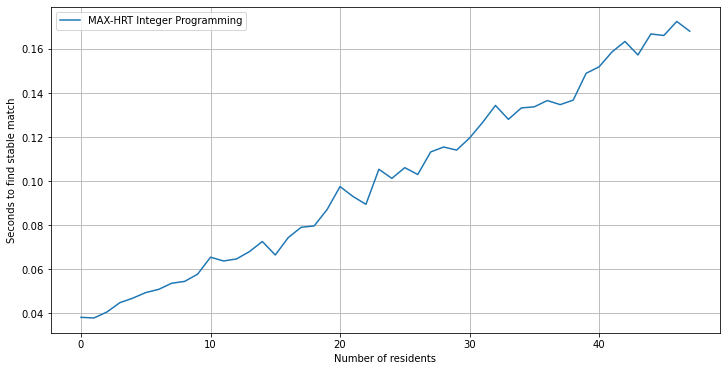

In [152]:
plt.figure(figsize=(12,6))
plt.plot(np.mean(np.array(excecution_times).reshape(-1,10), axis=1), label='MAX-HRT Integer Programming')
#plt.plot(excecution_times, label='MAX-HRT Integer Programming')
plt.xlabel('Number of residents')
plt.ylabel('Seconds to find stable match')
plt.grid()
plt.legend()